# First tutorial


In [28]:
# Load all required libraries
import os
import codecs
import numpy as np
import torch
from matplotlib import pyplot as plt
from torchvision import datasets
import torch.nn as nn

In [2]:
download = datasets.MNIST('/Users/kundankumar/Downloads/myDatabase/MNISTpytorch/',train = True, download=True)
dataPath = '/Users/kundankumar/Downloads/myDatabase/MNISTpytorch/raw/'

In [8]:
def parseByte(b):
    if isinstance(b,str):
        return ord(b)
    return b

In [4]:
def getInt(b):
    return int(codecs.encode(b,'hex'),16)

In [7]:
def readImageFile(path):
    with open(path,'rb') as f:
        data = f.read()
        assert getInt(data[:4])==2051
        length =getInt(data[4:8])
        nRows = getInt(data[8:12])
        nCols = getInt(data[12:16])
        images = []
        idx = 16
        for l in range(length):
            img = []
            images.append(img)
            for r in range(nRows):
                row = []
                img.append(row)
                for c in range(nCols):
                    row.append(parseByte(data[idx]))
                    idx +=1
        assert len(images) == length
        return torch.ByteTensor(images).view(-1,784)        

In [14]:
trainImages = readImageFile(os.path.join(dataPath,'train-images-idx3-ubyte'))
testImages = readImageFile(os.path.join(dataPath,'t10k-images-idx3-ubyte'))

In [11]:
def readLabelFile(path):
    with open(path,'rb') as f:
        data = f.read()
        assert getInt(data[:4]) == 2049
        length = getInt(data[4:8])
        labels = [parseByte(b) for b in data[8:]]
        assert len(labels) == length
        return torch.LongTensor(labels)

In [13]:
trainLabels = readLabelFile(os.path.join(dataPath,'train-labels-idx1-ubyte'))
testLabels = readLabelFile(os.path.join(dataPath,'t10k-labels-idx1-ubyte'))

In [15]:
# print number of training and testing images
print(trainImages.size())
print(testImages.size())
print(trainLabels.size())
print(testLabels.size())

torch.Size([60000, 784])
torch.Size([10000, 784])
torch.Size([60000])
torch.Size([10000])


In [22]:
def imgShow(img):
    img = img.view(28,28).numpy()
    plt.figure()
    plt.imshow(img,cmap = 'gray')
    plt.axis('off')

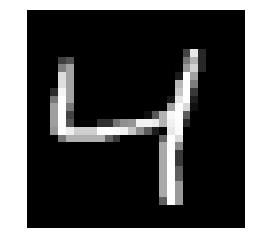

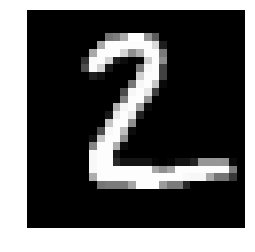

In [23]:
imgShow(trainImages[2,:])
imgShow(testImages[1,:])

In [24]:
# test GPU availability
useGPU = torch.cuda.is_available()
if useGPU:
    print('GPU is available')
else:
    print('GPU is not available')

GPU is not available


In [33]:
# Define the Autoencoder
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder,self).__init__()
        self.encoder = nn.Sequential(nn.Linear(28*28,100),nn.ReLU())
        self.decoder = nn.Sequential(nn.Linear(100,28*28),nn.ReLU())
        
    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [34]:
net = autoencoder()
print(net)

autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=100, out_features=784, bias=True)
    (1): ReLU()
  )
)


In [35]:
if useGPU:
    net = net.double().cuda()
else:
    net = net.double()

In [37]:
# Store initial weights in a variable
import copy
initWeights = copy.deepcopy(net.encoder[0].weight.data)

In [39]:
# define Criterion function and Optimizer
import torch.optim as optim
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(),lr = 0.5,momentum = 0.9)

# Train Autoencoder

In [52]:
from torch.autograd import Variable
iterations = 10
batchSize = 1000
for epoch in range(iterations):
    runningLoss = 0.0
    for i in range(trainImages.size()[0]/batchSize):
        inputs = torch.index_select(trainImages,0,torch.linspace(i*batchSize,\
                                        (i+1)*batchSize-1,steps = batchSize).long()).double()
        
    inputs = inputs/255
    # wrap them in Variable
    if useGPU:
        inputs = Variable(inputs).cuda()
    else:
        inputs = Variable(inputs)
                           
    optimizer.zero_grad()        
    outputs = net(inputs)
    loss = criterion(outputs,inputs)
    loss.backward()
    optimizer.step()
    
    runningLoss += loss.data.item()
    print('At Iteration : %d / %d  ;  Mean-Squared Error : %f'%(epoch + 1,iterations,\
                                                                        runningLoss/(60000/batchSize)))
                           
                           

At Iteration : 1 / 10  ;  Mean-Squared Error : 0.001902
At Iteration : 2 / 10  ;  Mean-Squared Error : 0.001891
At Iteration : 3 / 10  ;  Mean-Squared Error : 0.001874
At Iteration : 4 / 10  ;  Mean-Squared Error : 0.001852
At Iteration : 5 / 10  ;  Mean-Squared Error : 0.001827
At Iteration : 6 / 10  ;  Mean-Squared Error : 0.001801
At Iteration : 7 / 10  ;  Mean-Squared Error : 0.001773
At Iteration : 8 / 10  ;  Mean-Squared Error : 0.001745
At Iteration : 9 / 10  ;  Mean-Squared Error : 0.001717
At Iteration : 10 / 10  ;  Mean-Squared Error : 0.001687
